In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Bayesian
# ==============================================================================
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.metrics import classification_report
import xgboost as xgb
from collections import Counter
import time
import optuna
from optuna.samplers import TPESampler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

/Users/Cristobal/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#carga los datos
tabla_final = pd.read_csv('Tabla_final_colab.csv', sep = ",")


## Se borran columnas irrelevantes ##
tabla_final = tabla_final.drop('FECHA_DATO', axis=1)
tabla_final = tabla_final.drop('FECHA_PROCESO', axis=1)
tabla_final = tabla_final.drop('ID_PROD', axis=1)
tabla_final = tabla_final.drop('FLAG_PREAP', axis=1)

## Definimos una tabla con los id de clientes
## Para luego poeder funtarla con las prob ##
## Si se queda se considera como parametro ##
tabla_con_id_cliente = tabla_final

tabla_final = tabla_final.drop('ID_CLIENTE', axis=1)
#visualizamos los datos
tabla_final

,CT_CTE,DEBITO_DIR,ID_EMPLEADO,ID_SEGMENTO_VALOR,ANTIGUEDAD,RENTA,EDAD,EDAD_PUNTAJE,ID_GENERO,ACEPTADO
0,1.0,0.0,0.0,2.0,6.0,87218.10,36.0,3.0,1.0,0.0
1,1.0,0.0,0.0,1.0,35.0,122179.11,23.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,35.0,119775.54,23.0,1.0,1.0,0.0
3,1.0,0.0,0.0,1.0,35.0,22220.04,24.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,35.0,295590.36,24.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
602555,0.0,0.0,0.0,2.0,62.0,97397.16,41.0,6.0,1.0,0.0
602556,0.0,0.0,0.0,2.0,7.0,168445.62,34.0,2.0,0.0,0.0
602557,0.0,0.0,0.0,1.0,6.0,53689.02,24.0,1.0,1.0,0.0
602558,0.0,0.0,0.0,2.0,229.0,64404.21,61.0,7.0,0.0,0.0


In [3]:
# Split the data into features (X) and target (y)
X = tabla_final.drop('ACEPTADO', axis=1)
y = tabla_final['ACEPTADO']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
start_time = time.time()
def objective(trial):
    # Define the search space
    
    max_depth = trial.suggest_int('max_depth', 5, X_train.shape[1]) #profundidad máxima del árbol
    n_estimators=trial.suggest_int('n_estimators',125, 200) #número de ramas en el árbol
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20) #mínimo de muestras en el nodo para que se pueda dividir
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20) #mínimo de muestras en un nodo para que sea considerado una hoja
    min_impurity_decrease  = trial.suggest_float('min_impurity_decrease', 0, 1) #mínimo para supervisar si es necesario separar un nodo.
    
    model = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_split= min_samples_split, min_samples_leaf=min_samples_leaf, min_impurity_decrease=min_impurity_decrease)
    
    score = cross_val_score(model, X_train, y_train, scoring='accuracy',
                            cv=4).mean()
    return score
study_DT = optuna.create_study(study_name="dectree_artf",
                            direction="maximize",
                            sampler=TPESampler())
study_DT.optimize(objective, n_trials=20)
print("--- {} minutos para el tuneo---".format((time.time() - start_time)/60))

[I 2023-06-21 14:38:20,904] A new study created in memory with name: dectree_artf
[I 2023-06-21 14:38:48,878] Trial 0 finished with value: 0.9265176911842804 and parameters: {'max_depth': 6, 'n_estimators': 185, 'min_samples_split': 15, 'min_samples_leaf': 13, 'min_impurity_decrease': 0.9388690805462695}. Best is trial 0 with value: 0.9265176911842804.
[I 2023-06-21 14:39:09,776] Trial 1 finished with value: 0.9265176911842804 and parameters: {'max_depth': 6, 'n_estimators': 139, 'min_samples_split': 7, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.15932168502358013}. Best is trial 0 with value: 0.9265176911842804.
[I 2023-06-21 14:39:32,780] Trial 2 finished with value: 0.9265176911842804 and parameters: {'max_depth': 7, 'n_estimators': 156, 'min_samples_split': 3, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.8601376652452996}. Best is trial 0 with value: 0.9265176911842804.
[I 2023-06-21 14:39:52,707] Trial 3 finished with value: 0.9265176911842804 and parameters: {'max_dept

--- 8.09677123228709 minutos para el tuneo---


In [5]:
print(study_DT.best_params)

{'max_depth': 6, 'n_estimators': 185, 'min_samples_split': 15, 'min_samples_leaf': 13, 'min_impurity_decrease': 0.9388690805462695}


In [5]:
#param_dist = {'n_estimators': randint(80,120),
#              'max_depth': randint(8,12)}

# Create a random forest classifier
#rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
#rand_search = RandomizedSearchCV(rf, 
#                                 param_distributions = param_dist, 
#                                 n_iter=5, 
#                                 cv=5)

# Fit the random search object to the data
#rand_search.fit(X_train, y_train)

In [6]:
# Create a variable for the best model
#best_rf = rand_search.best_estimator_

# Print the best hyperparameters
#print('Best hyperparameters:',  rand_search.best_params_)

#### Best hyperparameters: {'max_depth': 9} #####

In [7]:
# Generate predictions with the best model
#y_pred = best_rf.predict(X_test)

# Create the confusion matrix
#cm = confusion_matrix(y_test, y_pred)

#ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [8]:
#y_pred = best_rf.predict(X_test)

#accuracy = accuracy_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred)

#print("Accuracy:", accuracy)
#print("Precision:", precision)
#print("Recall:", recall)

In [9]:
#param_dist = {'n_estimators': randint(80,120)}

# Create a random forest classifier
#rf = RandomForestClassifier(max_depth = 9)

# Use random search to find the best hyperparameters
#rand_search = RandomizedSearchCV(rf, 
#                                param_distributions = param_dist, 
#                                 n_iter=5, 
#                                 cv=5)

# Fit the random search object to the data
#rand_search.fit(X_train, y_train)

In [10]:
# Create a variable for the best model
#best_rf = rand_search.best_estimator_

# Print the best hyperparameters
#print('Best hyperparameters:',  rand_search.best_params_)

##### Best hyperparameters: {'n_estimators': 110} ###

In [11]:
##### Caso con parametros optimos ####

best_rf = RandomForestClassifier(max_depth = 6, n_estimators = 185, min_samples_split= 15, min_samples_leaf=13, min_impurity_decrease=0.9388690805462695)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [12]:
#### Indicadores de desempeño ###

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

### CON ID CLIENTE ###
#Accuracy: 0.9387741500729408
#Precision: 0.6155514767228433
#Recall: 0.3821609862218999

### CON TABLA ANTIGUA SIN FILTROS ###
#Accuracy: 0.9370191275242333
#Precision: 0.6259222333000997
#Recall: 0.32135544635544633

Accuracy: 0.9356827535847052
Precision: 0.6078617546524877
Recall: 0.36018904017103637


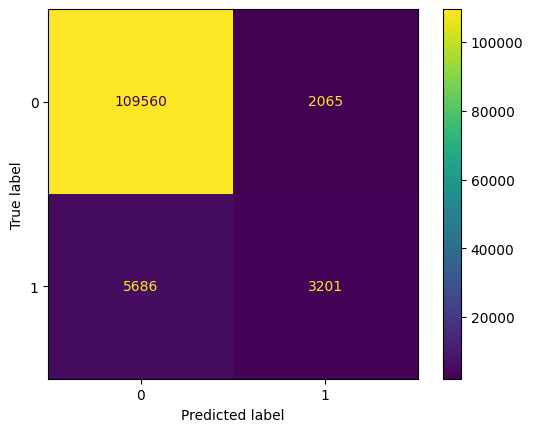

In [13]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: >

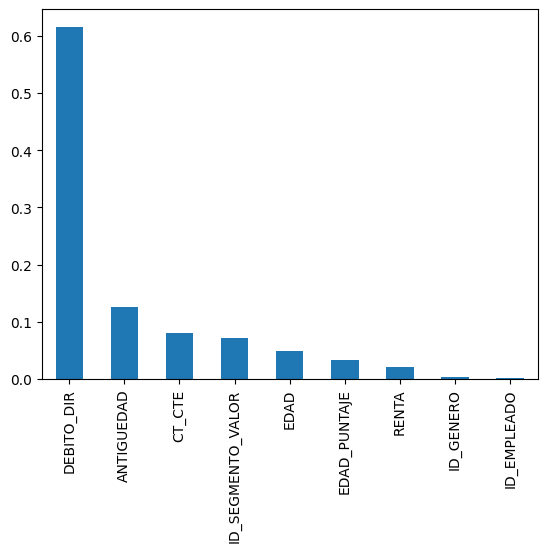

In [14]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

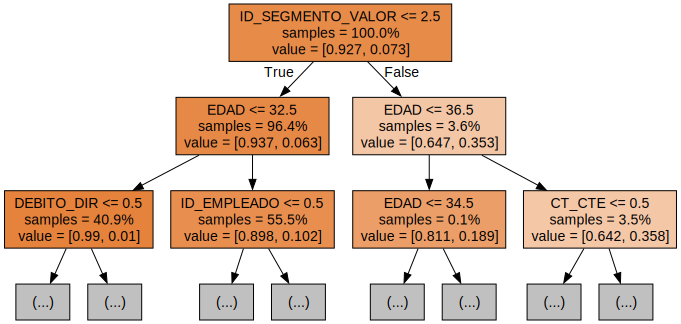

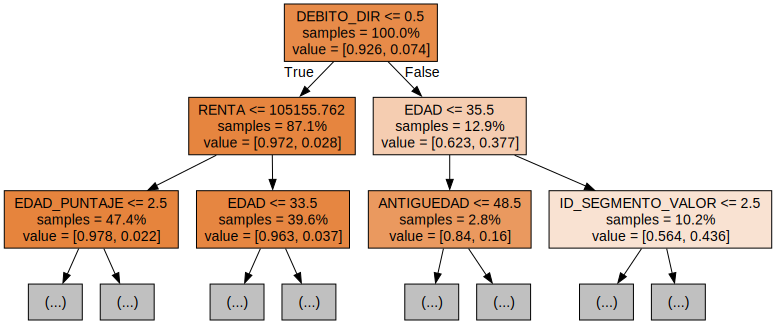

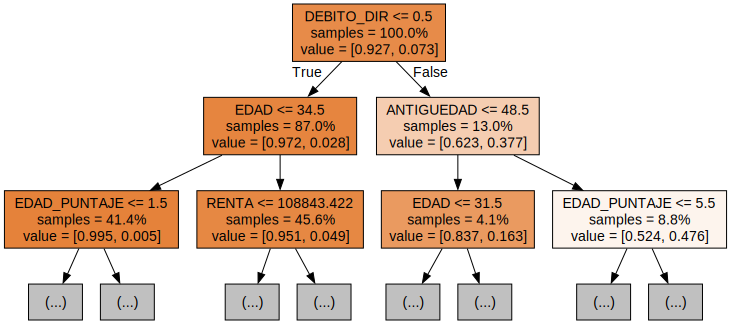

In [15]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [16]:
probabilidades = best_rf.predict_proba(X)
probabilidad_de_aceptar = []

for i in range (0,len(probabilidades)):
    probabilidad_de_aceptar.append(probabilidades[i][1])

df = pd.DataFrame({'probabilidad_de_aceptar':probabilidad_de_aceptar})
df

,probabilidad_de_aceptar
0,0.020052
1,0.002083
2,0.003266
3,0.001010
4,0.003317
...,...
602555,0.028629
602556,0.024702
602557,0.000943
602558,0.032285


In [17]:
tabla_con_id_cliente_mas_probabilidad = pd.merge(tabla_con_id_cliente, df, left_index=True, right_index=True)

tabla_con_id_cliente_mas_probabilidad

,CT_CTE,DEBITO_DIR,ID_EMPLEADO,ID_SEGMENTO_VALOR,ANTIGUEDAD,ID_CLIENTE,RENTA,EDAD,EDAD_PUNTAJE,ID_GENERO,ACEPTADO,probabilidad_de_aceptar
0,1.0,0.0,0.0,2.0,6.0,1375586.0,87218.10,36.0,3.0,1.0,0.0,0.020052
1,1.0,0.0,0.0,1.0,35.0,1050612.0,122179.11,23.0,1.0,0.0,0.0,0.002083
2,0.0,0.0,0.0,1.0,35.0,1050613.0,119775.54,23.0,1.0,1.0,0.0,0.003266
3,1.0,0.0,0.0,1.0,35.0,1050615.0,22220.04,24.0,1.0,1.0,0.0,0.001010
4,1.0,0.0,0.0,1.0,35.0,1050616.0,295590.36,24.0,1.0,1.0,0.0,0.003317
...,...,...,...,...,...,...,...,...,...,...,...,...
602555,0.0,0.0,0.0,2.0,62.0,899549.0,97397.16,41.0,6.0,1.0,0.0,0.028629
602556,0.0,0.0,0.0,2.0,7.0,1441442.0,168445.62,34.0,2.0,0.0,0.0,0.024702
602557,0.0,0.0,0.0,1.0,6.0,1454431.0,53689.02,24.0,1.0,1.0,0.0,0.000943
602558,0.0,0.0,0.0,2.0,229.0,56812.0,64404.21,61.0,7.0,0.0,0.0,0.032285


In [18]:
tabla_con_id_cliente_mas_probabilidad = tabla_con_id_cliente_mas_probabilidad.sort_values(by='probabilidad_de_aceptar', ascending = False)
tabla_con_id_cliente_mas_probabilidad.dropna()

,CT_CTE,DEBITO_DIR,ID_EMPLEADO,ID_SEGMENTO_VALOR,ANTIGUEDAD,ID_CLIENTE,RENTA,EDAD,EDAD_PUNTAJE,ID_GENERO,ACEPTADO,probabilidad_de_aceptar
276008,0.0,1.0,1.0,3.0,246.0,16019.0,256018.08,56.0,7.0,0.0,1.0,0.842548
276082,0.0,1.0,0.0,3.0,246.0,15892.0,430477.41,62.0,7.0,1.0,1.0,0.836934
276067,0.0,1.0,0.0,3.0,246.0,15921.0,419503.62,62.0,7.0,0.0,1.0,0.835354
276366,0.0,1.0,0.0,3.0,242.0,18332.0,351628.89,59.0,7.0,0.0,1.0,0.829836
276019,0.0,1.0,1.0,3.0,244.0,16007.0,185300.25,50.0,8.0,1.0,1.0,0.829343
...,...,...,...,...,...,...,...,...,...,...,...,...
597675,1.0,0.0,0.0,1.0,1.0,1437679.0,29118.30,22.0,1.0,1.0,0.0,0.000530
601946,1.0,0.0,0.0,1.0,2.0,1453334.0,30065.31,21.0,1.0,1.0,0.0,0.000516
597165,1.0,0.0,0.0,1.0,2.0,1423064.0,29039.25,21.0,1.0,1.0,0.0,0.000516
597434,1.0,0.0,0.0,1.0,2.0,1417728.0,28669.83,21.0,1.0,1.0,0.0,0.000516


In [19]:
tabla_con_id_cliente_mas_probabilidad.to_csv(r'C:\Users\marti\Desktop\Capstone\procesamiento de datos\Resultados_Random_Forest.csv', index=False, header=True)